# Sparkify Project Notebook

This notebook is prepared for the Sparkify Capstone project needed to complete the Udacity Data Science Nanodegree.

It is intended to be dpeloyed on an Amazon EMR cluster and make use of the full dataset available (12GB).

## 1. Import libraries

In [1]:
from pyspark.sql.functions import udf, min, max, countDistinct
from pyspark.sql.functions import sum as Ssum
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re

from datetime import datetime

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1624363049263_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
#Install matplotlib from given PyPI repository
sc.install_pypi_package("matplotlib", "https://pypi.org/simple") 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# Check installation
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.3    
boto                       2.49.0   
click                      7.1.2    
cycler                     0.10.0   
jmespath                   0.10.0   
joblib                     1.0.1    
kiwisolver                 1.3.1    
lxml                       4.6.2    
matplotlib                 3.4.2    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
Pillow                     8.2.0    
pip                        9.0.1    
py-dateutil                2.2      
pyparsing                  2.4.7    
python-dateutil            2.8.1    
python37-sagemaker-pyspark 1.4.1    
pytz                       2021.1   
PyYAML                     5.4.1    
regex                      2021.3.17
setuptools                 28.8.0   
six                        1.13.0   
tqdm                       4.59.0   
w

In [4]:
# Import
from matplotlib import pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2. Load and Clean Dataset

In [19]:
# Define path
# Mini dataset
# path = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
# Full dataset
path ="s3n://udacity-dsnd/sparkify/sparkify_event_data.json"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
# Load & Persist data
df_user_log = spark.read.json(path)
df_user_log.persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [21]:
# Check schema
df_user_log.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [22]:
# Show the first row
df_user_log.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042')

In [23]:
# Check num of rows, columns
print('Number of rows: ', df_user_log.count(), '; Number of columns: ', len(df_user_log.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows:  26259199 ; Number of columns:  18

We can eliminate `NaN` in `userId` or `sessionId`, and take care of the cases of empty users too: 

In [24]:
# Drop NaN
df_user_log_valid = df_user_log.dropna(how = "any", subset = ["userId", "sessionId"])
# Drop empty users
df_user_log_valid = df_user_log_valid.filter(df_user_log_valid["userId"] != "")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
# Check updated num of rows, columns
print('Number of rows: ', df_user_log_valid.count(), '; Number of columns: ', len(df_user_log_valid.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows:  26259199 ; Number of columns:  18

## 3. Define Churn variable

In [26]:
# Check available pages
df_user_log.select("page").dropDuplicates().sort("page").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows

In [27]:
# Defining a churn variable based on the Cancellation Confirmation page
cancellation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())  
df_user_log_valid = df_user_log_valid.withColumn("churn", cancellation("page"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
# show columns
df_user_log_valid.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042', churn=0)

In [29]:
# Create a list of users that cancelled vs. users that stayed
users_cancelled = df_user_log_valid.select(["userId"]).where(df_user_log_valid.churn == 1).dropDuplicates().collect()
users_staying = df_user_log_valid.select(["userId"]).where(df_user_log_valid.churn == 0).dropDuplicates().collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
print('Num. of users that cancelled: ', len(users_cancelled), '; Num. of users staying: ', len(users_staying))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Num. of users that cancelled:  5003 ; Num. of users staying:  22278

In [31]:
# Select a subset of the dataframe with the users that left
users_cancelled_list = [us_c[0] for us_c in users_cancelled]
df_user_log_cancelled = df_user_log_valid.filter(df_user_log_valid.userId.isin(users_cancelled_list))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
# Select a subset of the dataframe with the users that are staying
users_staying_list = [us_s[0] for us_s in users_staying]
df_user_log_staying = df_user_log_valid.filter(df_user_log_valid.userId.isin(users_staying_list))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
# Check dta frames sizes
print('# of Rows of the dataframe of users that cancelled: ', df_user_log_cancelled.count())
print('# of Rows of the dataframe of users that are staying: ', df_user_log_staying.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# of Rows of the dataframe of users that cancelled:  5382467
# of Rows of the dataframe of users that are staying:  26259199

## 4. Data exploration

### 4.1. Number of days spent, Number of songs per day

Let's take a look at the time spent with the service, and the number of songs listened per day.  

For each user, we'll calculate the number of days based on the first and last timestamp, and then divide the number of songs for the number of days.

**Cancelling Users**

In [34]:
# Select, for every user that cancelled, the number of songs and the time span they spent with the service
song_time_canc = df_user_log_cancelled.\
                filter(df_user_log_cancelled["song"] != "").\
                groupBy("userId").\
                agg(min("ts"), max("ts"), countDistinct("song")).\
                collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
# Get the time difference
delta_time_cancelled = [(song_time[2]/1000 - song_time[1]/1000)/(3600*24) for song_time in song_time_canc]
# Get the number of songs listened per day day (on average)
# NOTE: the if clause is needed for the cases in which a user has listened to just one song before leaving, and so 
# there would be only one timestamp associated with the event
num_songs_cancelled = [song_time[3]/((song_time[2]/1000 - song_time[1]/1000)/(3600*24)) \
                       if ((song_time[2]/1000 - song_time[1]/1000)/(3600*24)) \
                       else 1.0 for song_time in song_time_canc]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Users Staying**

In [36]:
# Select, for every user that stays, the number of songs and the time span they spent with the service
song_time_stay = df_user_log_staying.\
                filter(df_user_log_staying["song"] != "").\
                groupBy("userId").\
                agg(min("ts"), max("ts"), countDistinct("song")).\
                collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
# Get the time difference
delta_time_staying = [(song_time[2]/1000 - song_time[1]/1000)/(3600*24) for song_time in song_time_stay]
# Get the number of songs listened per day day (on average)
# NOTE: the if clause is needed for the cases in which a user has listened to just one song before leaving, and so 
# there would be only one timestamp associated with the event
num_songs_staying = [song_time[3]/((song_time[2]/1000 - song_time[1]/1000)/(3600*24)) \
                       if ((song_time[2]/1000 - song_time[1]/1000)/(3600*24)) \
                       else 1.0 for song_time in song_time_stay]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Plots/Statistics**

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

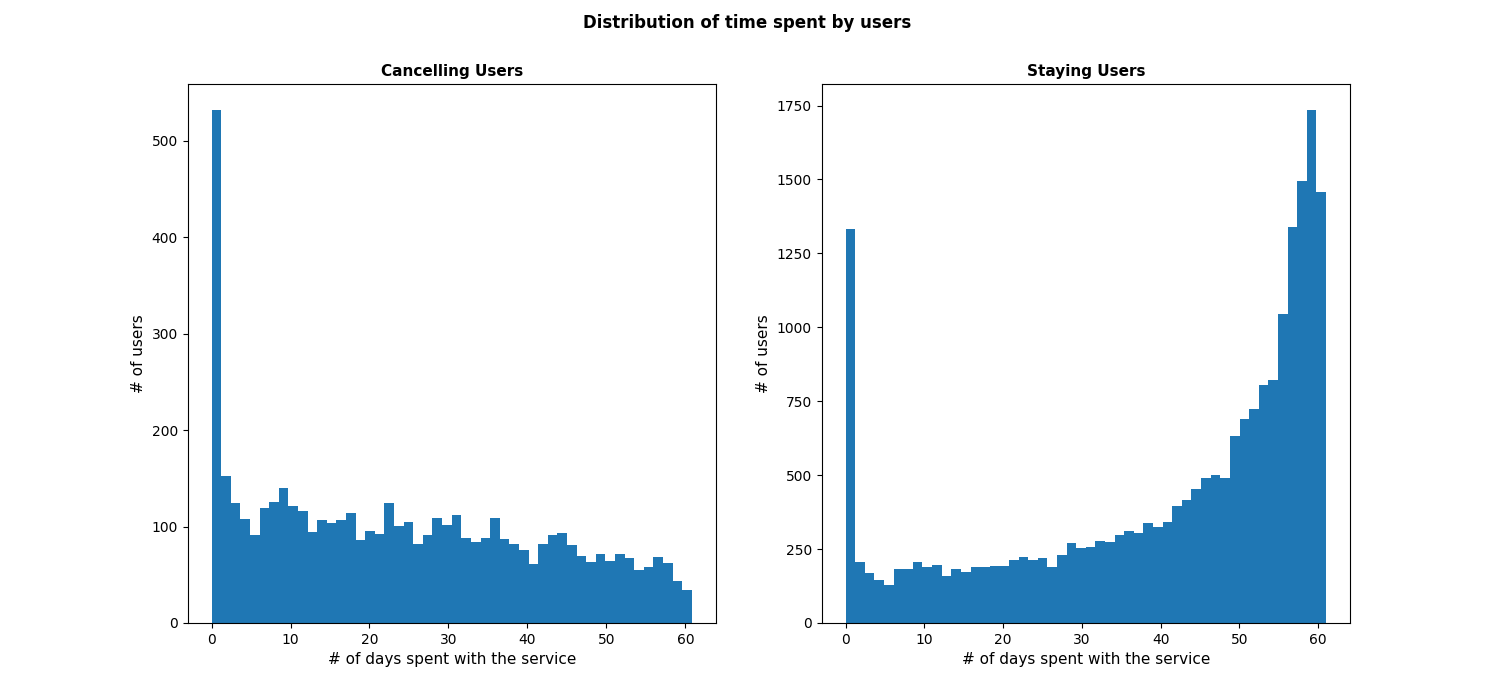

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of time spent by users ', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(delta_time_cancelled, bins=50)
ax1.set_xlabel('# of days spent with the service', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(delta_time_staying, bins=50)
ax2.set_xlabel('# of days spent with the service', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

%matplot plt

In [39]:
# Look at the statistics
print('Statistics for time spent with the service for users that cancelled:')
spark.createDataFrame(delta_time_cancelled, FloatType()).describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Statistics for time spent with the service for users that cancelled:
+-------+------------------+
|summary|             value|
+-------+------------------+
|  count|              5002|
|   mean|24.236902227921572|
| stddev|17.690378886277752|
|    min|               0.0|
|    max|          60.82044|
+-------+------------------+

In [40]:
# Look at the statistics
print('Statistics for time spent with the service for users that are staying:')
spark.createDataFrame(delta_time_staying, FloatType()).describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Statistics for time spent with the service for users that are staying:
+-------+------------------+
|summary|             value|
+-------+------------------+
|  count|             22261|
|   mean|40.675792643424835|
| stddev|  18.9854762798364|
|    min|               0.0|
|    max|         60.999504|
+-------+------------------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

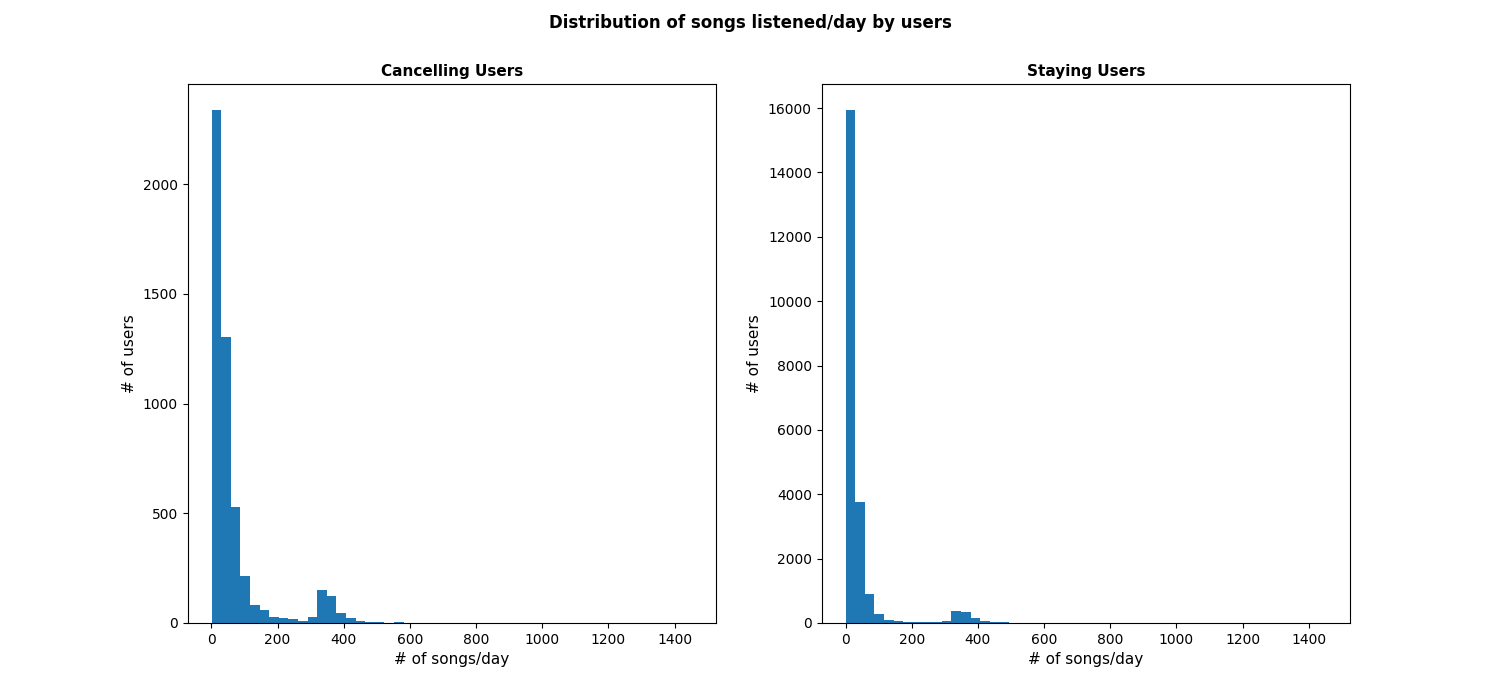

In [41]:
# Plot histogram for songs
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of songs listened/day by users', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(num_songs_cancelled, bins=50)
ax1.set_xlabel('# of songs/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(num_songs_staying, bins=50)
ax2.set_xlabel('# of songs/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

%matplot plt

In [42]:
# Look at the statistics
print('Statistics for songs/day for users that cancelled:')
spark.createDataFrame(num_songs_cancelled, FloatType()).describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Statistics for songs/day for users that cancelled:
+-------+------------------+
|summary|             value|
+-------+------------------+
|  count|              5002|
|   mean| 67.22089404627377|
| stddev|101.09707031180494|
|    min|         0.2437962|
|    max|         1452.1008|
+-------+------------------+

In [43]:
# Look at the statistics
print('Statistics for songs/day for users that stay:')
spark.createDataFrame(num_songs_staying, FloatType()).describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Statistics for songs/day for users that stay:
+-------+-----------------+
|summary|            value|
+-------+-----------------+
|  count|            22261|
|   mean|40.91689135214914|
| stddev| 85.3892471170439|
|    min|      0.103192024|
|    max|        1452.1008|
+-------+-----------------+

In [44]:
spark.createDataFrame(num_songs_cancelled, FloatType()).approxQuantile("value", [0.25, 0.5, 0.75], 0.25)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.2437961995601654, 664.6153564453125, 1452.100830078125]

In [45]:
spark.createDataFrame(num_songs_staying, FloatType()).approxQuantile("value", [0.25, 0.5, 0.75], 0.25)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.10319202393293381, 807.4766235351562, 1452.100830078125]

### 4.2. Roll Advert/Add Friend

Other maybe useful pages are thoe marked as `Roll Advert` or `Add Friend`

In [46]:
# Defining a roll_adv variable based on the Roll Advert page
roll_adv = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())  

df_user_log_cancelled = df_user_log_cancelled.withColumn("roll_adv", roll_adv("page"))
df_user_log_staying = df_user_log_staying.withColumn("roll_adv", roll_adv("page"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
# Defining an add_friend variable based on the Add Friend page
add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())  

df_user_log_cancelled = df_user_log_cancelled.withColumn("add_friend", add_friend("page"))
df_user_log_staying = df_user_log_staying.withColumn("add_friend", add_friend("page"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
# Check columns - cancelled
df_user_log_cancelled.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042', churn=0, roll_adv=0, add_friend=0)

In [49]:
# Check columns - staying
df_user_log_staying.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042', churn=0, roll_adv=0, add_friend=0)

**Cancelling Users**

In [66]:
# Parse the df of cancelled users to get the total number of added friend/user
added_friend_canc = df_user_log_cancelled.\
                groupBy("userId").\
                agg(min("ts"), max("ts"), Ssum("add_friend")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
# Calculate the number of added friends per day
# NOTE: the if clause is needed for the cases in which a user has listened to just one song before leaving, and so 
# there would be only one timestamp associated with the event
added_friend_event_canc = [added_friend[3]/((added_friend[2]/1000 - added_friend[1]/1000)/(3600*24)) \
                           if ((added_friend[2]/1000 - added_friend[1]/1000)/(3600*24)) \
                           else 1.0 for added_friend in added_friend_canc]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
# Parse the df of cancelled users to get the total number of advert rolled/user
rolled_advert_canc = df_user_log_cancelled.\
                groupBy("userId").\
                agg(min("ts"), max("ts"), Ssum("roll_adv")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
# Calculate the number of rolled adverts per day
# NOTE: the if clause is needed for the cases in which a user has listened to just one song before leaving, and so 
# there would be only one timestamp associated with the event
rolled_advert_event_canc = [rolled_adv[3]/((rolled_adv[2]/1000 - rolled_adv[1]/1000)/(3600*24)) \
                           if ((rolled_adv[2]/1000 - rolled_adv[1]/1000)/(3600*24)) \
                           else 1.0 for rolled_adv in rolled_advert_canc]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Staying Users**

In [70]:
# Parse the df of staying users to get the total number of added friend/user
added_friend_stay = df_user_log_staying.\
                groupBy("userId").\
                agg(min("ts"), max("ts"), Ssum("add_friend")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [71]:
# Calculate the number of added friends per day
# NOTE: the if clause is needed for the cases in which a user has listened to just one song before leaving, and so 
# there would be only one timestamp associated with the event
added_friend_event_stay = [added_friend[3]/((added_friend[2]/1000 - added_friend[1]/1000)/(3600*24)) \
                           if ((added_friend[2]/1000 - added_friend[1]/1000)/(3600*24)) \
                           else 1.0 for added_friend in added_friend_stay]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
# Parse the df of staying users to get the total number of advert rolled/user
rolled_advert_stay = df_user_log_staying.\
                groupBy("userId").\
                agg(min("ts"), max("ts"), Ssum("roll_adv")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [73]:
# Calculate the number of rolled adverts per day
# NOTE: the if clause is needed for the cases in which a user has listened to just one song before leaving, and so 
# there would be only one timestamp associated with the event
rolled_advert_event_stay = [rolled_adv[3]/((rolled_adv[2]/1000 - rolled_adv[1]/1000)/(3600*24)) \
                           if ((rolled_adv[2]/1000 - rolled_adv[1]/1000)/(3600*24)) \
                           else 1.0 for rolled_adv in rolled_advert_stay]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Plots/Statistics**

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

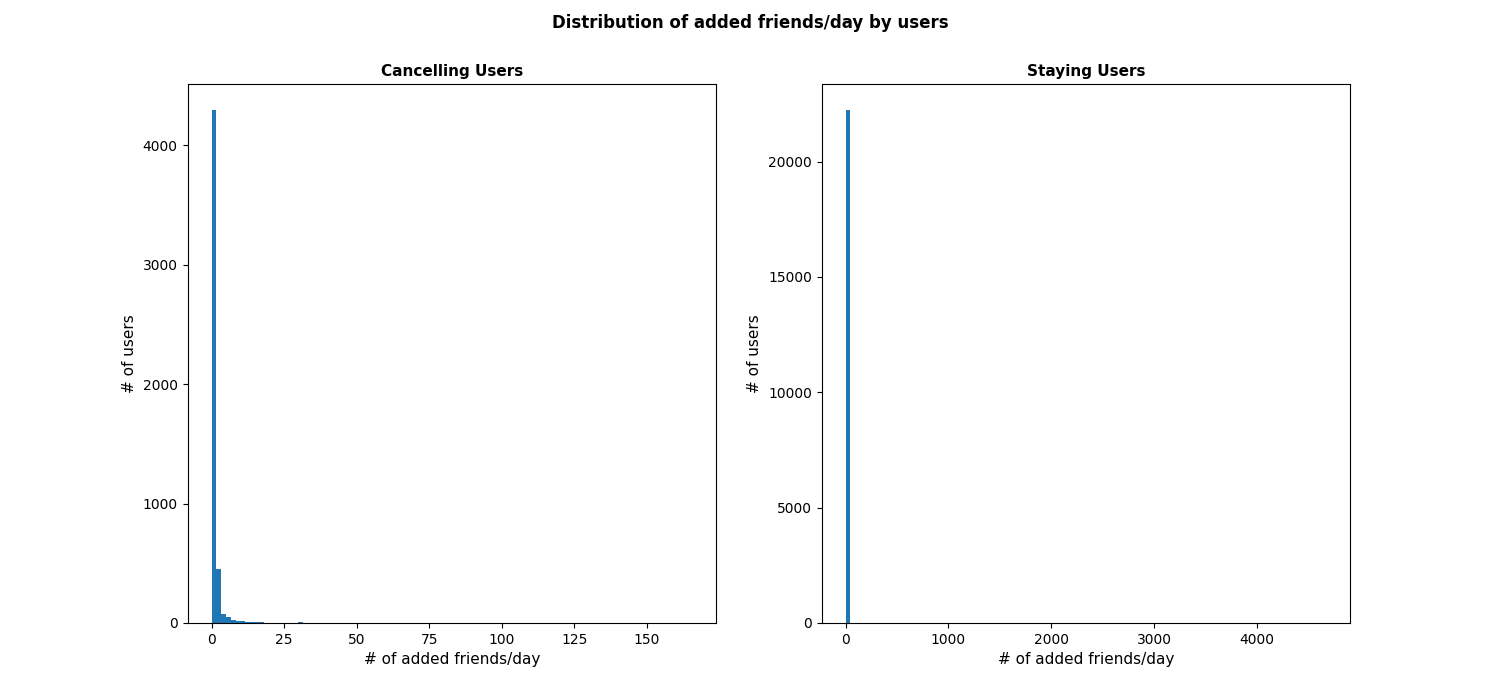

In [74]:
# Plot histogram for added friends
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of added friends/day by users', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(added_friend_event_canc, bins=100)
ax1.set_xlabel('# of added friends/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(added_friend_event_stay, bins=100)
ax2.set_xlabel('# of added friends/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

%matplot plt

In [75]:
# Look at the statistics
print('Statistics for added friend/day for users that cancelled:')
spark.createDataFrame(added_friend_event_canc, FloatType()).describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Statistics for added friend/day for users that cancelled:
+-------+------------------+
|summary|             value|
+-------+------------------+
|  count|              5003|
|   mean|1.2849585002665367|
| stddev| 4.684417942761355|
|    min|               0.0|
|    max|         165.51724|
+-------+------------------+

In [76]:
# Look at the statistics
print('Statistics for added friend/day for users that stay:')
spark.createDataFrame(added_friend_event_stay, FloatType()).describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Statistics for added friend/day for users that stay:
+-------+------------------+
|summary|             value|
+-------+------------------+
|  count|             22278|
|   mean|0.9894135130330384|
| stddev| 31.56827156102051|
|    min|               0.0|
|    max|         4670.2705|
+-------+------------------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

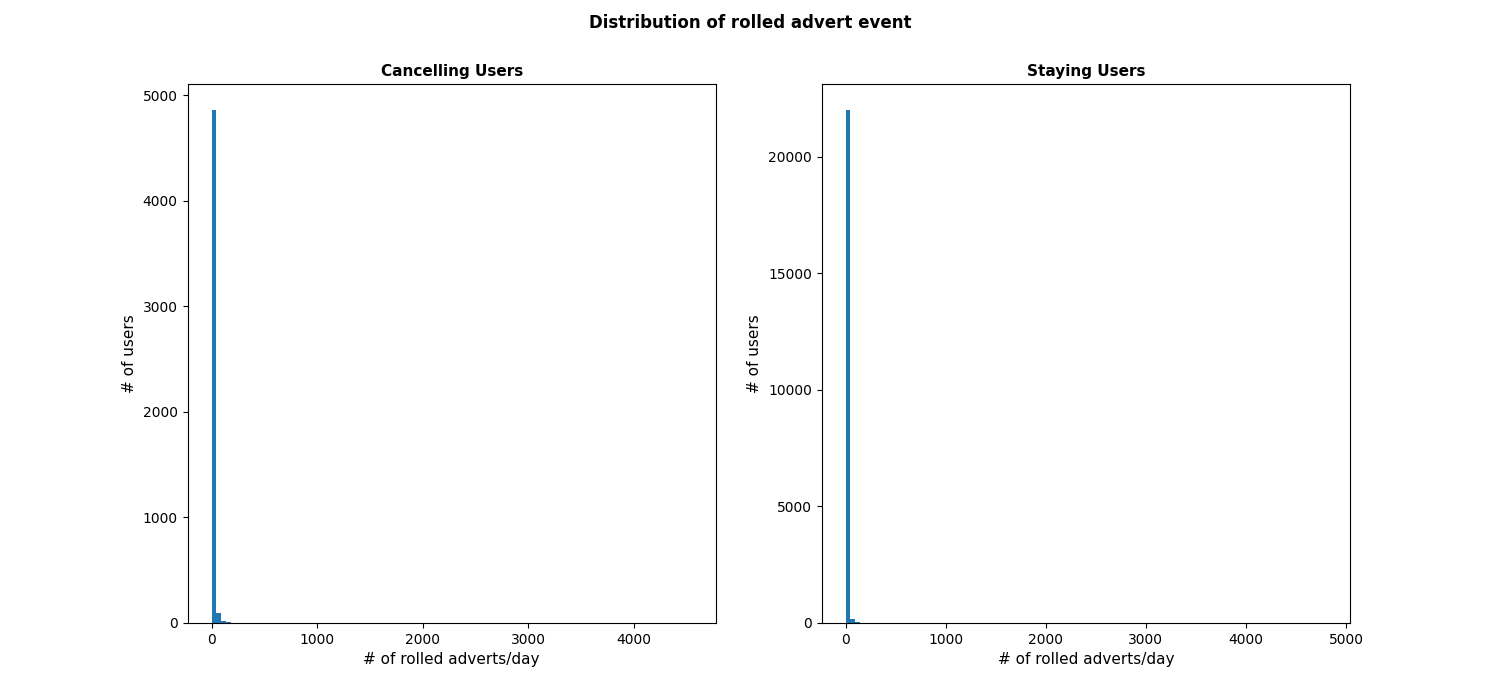

In [77]:
# Plot histogram for rolled advert
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of rolled advert event', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(rolled_advert_event_canc, bins=100)
ax1.set_xlabel('# of rolled adverts/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(rolled_advert_event_stay, bins=100)
ax2.set_xlabel('# of rolled adverts/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

%matplot plt

In [78]:
# Look at the statistics
print('Statistics for rolled advert/day for users that cancelled:')
spark.createDataFrame(rolled_advert_event_canc, FloatType()).describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Statistics for rolled advert/day for users that cancelled:
+-------+-----------------+
|summary|            value|
+-------+-----------------+
|  count|             5003|
|   mean|6.281575371243779|
| stddev|78.25946934848248|
|    min|              0.0|
|    max|        4547.3687|
+-------+-----------------+

In [79]:
# Look at the statistics
print('Statistics for rolled advert/day for users that stay:')
spark.createDataFrame(rolled_advert_event_stay, FloatType()).describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Statistics for rolled advert/day for users that stay:
+-------+-----------------+
|summary|            value|
+-------+-----------------+
|  count|            22278|
|   mean|2.769251988135614|
| stddev|50.51804649704249|
|    min|              0.0|
|    max|           4800.0|
+-------+-----------------+

### 4.3. Downgrade Plan

Another option could be to check how many downgrades of a plan (from paid to free) were actually submitted for the two families of users.

In [82]:
# Check available levels
df_user_log.select("level").dropDuplicates().sort("level").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+
|level|
+-----+
| free|
| paid|
+-----+

In [85]:
# Defining a sub_dwg variable based on the Submit Downgrade page
sub_dwg = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())  

df_user_log_cancelled = df_user_log_cancelled.withColumn("sub_dwg", sub_dwg("page"))
df_user_log_staying = df_user_log_staying.withColumn("sub_dwg", sub_dwg("page"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
# Defining a pay_plan variable based on the Level page
pay_plan = udf(lambda x: 1 if x == "paid" else 0, IntegerType())  

df_user_log_cancelled = df_user_log_cancelled.withColumn("pay_plan", pay_plan("level"))
df_user_log_staying = df_user_log_staying.withColumn("pay_plan", pay_plan("level"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [87]:
# Check columns - cancelled
df_user_log_cancelled.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042', churn=0, roll_adv=0, add_friend=0, sub_dwg=0, pay_plan=1)

In [88]:
# Check columns - staying
df_user_log_staying.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042', churn=0, roll_adv=0, add_friend=0, sub_dwg=0, pay_plan=1)

**Cancelled Users**

In [89]:
# Sum the total number of downgrading actions
downgrade_canc = df_user_log_cancelled.select(Ssum("sub_dwg")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [91]:
# Parse df to collect all the cases in which the plan was/is paid
pay_plan_canc = df_user_log_cancelled.\
                groupBy("userId").\
                agg(max("pay_plan")).collect()

# Convert to list
pay_plan_canc_list = [pay_plan_status[1] for pay_plan_status in pay_plan_canc]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Staying Users**

In [92]:
# Sum the total number of downgrading actions
downgrade_stay = df_user_log_staying.select(Ssum("sub_dwg")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [93]:
# Parse df to collect all the cases in which the plan was/is paid
pay_plan_stay = df_user_log_staying.\
                groupBy("userId").\
                agg(max("pay_plan")).collect()

# Convert to list
pay_plan_stay_list = [pay_plan_status[1] for pay_plan_status in pay_plan_stay]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Statistics**

In [100]:
print('Percentage of downgrades from paid to free (cancelled users): ', \
      '{:.1f}'.format(downgrade_canc[0][0]/sum(pay_plan_canc_list) * 100),' %')

print('Percentage of downgrades from paid to free (staying users): ', \
      '{:.1f}'.format(downgrade_stay[0][0]/sum(pay_plan_stay_list) * 100),' %')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Percentage of downgrades from paid to free (cancelled users):  38.6  %
Percentage of downgrades from paid to free (staying users):  40.1  %